# Key-Recovery Attacks on GCM with Repeated Nonces

1. GMAC:
    AD*y^3 + C*y^2 + L*y + S
    AD = blocks of Associated Data
    C  = blocks of ciphertext
    L  = encoded length of AD and C
    S  = block used to mask the output
    y  = Authentication key

2. Attacker knows AD, C and L

3. The masking block is generated using only the key and the nonce. If
   the nonce is repeated, the mask is the same. If we can collect two
   messages encrypted under the same nonce, they'll have used the same
   mask.

4. We can recover the key by XORing the two messages together. It will cancel out the S block and leave us with the key.

in GF(2):
  Addition: XOR
  Multiplication:
  ```go
    function modmul(a, b, m):
        p := mul(a, b)
        q, r := divmod(p, m)
        return r
  ```
  or more efficiently:
  ```go
    function modmul(a, b, m):
        p := 0
        while a > 0:
            if a & 1:
                p := p ^ b
            a := a >> 1
            b := b << 1
            if deg(b) = deg(m):
                b := b ^ m
        return p
  ```

# Implement AES-GCM

It's like CTR + authentication

The GF(2^128) field used is defined by the polynomial
    x^{128}+x^{7}+x^{2}+x+1

GHASH(H,A,C) = X_m+n+1_ , where:
  H = Hash key, string of 16 zero bytes encrypted using the block cipher
  A = Associated data (not encrypted)
  C = Ciphertext (encrypted)
  X :

  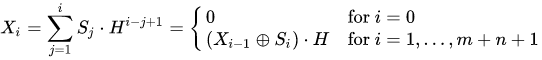

  Where S:

  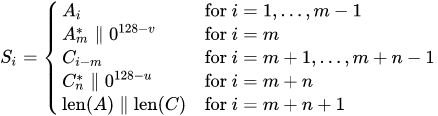
  
  A and C are 0 padded to the next multiple of 128 bits
  len(A) and len(C) are encoded as 64 bit modulo 128

  and initial counter, counter0 is:
  
  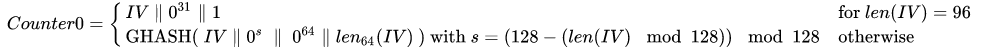

In [189]:
from utils import xor, get_blocks, BLOCKSIZE
from aes import aes_ecb_encrypt
from Crypto.Util.number import bytes_to_long, long_to_bytes

# x^128 + x^7 + x^2 + x + 1
GCM_MODULUS = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1] 

def int_to_bits(n: int) -> list:
    bits = [int(x) for x in bin(n)[2:]]
    # pad missing powers with 0
    bits = [0] * (128 - len(bits)) + bits
    return bits

def bits_to_int(bits: list) -> int:
    return int(''.join([str(x) for x in bits]), 2)

def deg(bits: list) -> int:
    return len(bits) - 1

def modmul(x_list: list, y_list: list) -> list:
    x = bits_to_int(x_list)
    y = bits_to_int(y_list)
    assert x < (1 << 128)
    assert y < (1 << 128)
    res = 0
    for i in range(127, -1, -1):
        res ^= x * ((y >> i) & 1)  # branchless
        x = (x >> 1) ^ ((x & 1) * 0xE1000000000000000000000000000000)
    assert res < 1 << 128
    return int_to_bits(res)

def modadd(a: list, b: list) -> list:
    # just xor
    return int_to_bits(bits_to_int(a) ^ bits_to_int(b))

def ghash(h_bytes: bytes, associated_data: bytes, ciphertext: bytes) -> bytes:
    h = int_to_bits(bytes_to_long(h_bytes))
    g = int_to_bits(0)
    # get length before padding
    length_block = gLen(associated_data) + gLen(ciphertext)
    # pad associated_data and ciphertext with 0s
    if len(associated_data) % BLOCKSIZE:
        associated_data = associated_data + bytes((BLOCKSIZE-len(associated_data)%BLOCKSIZE)%BLOCKSIZE) # pad AAD with 0s
    else:
        associated_data = associated_data
    if len(ciphertext) % BLOCKSIZE:
        ciphertext = ciphertext + bytes((BLOCKSIZE-len(ciphertext)%BLOCKSIZE)%BLOCKSIZE) # pad ciphertext with 0s
    else:
        ciphertext = ciphertext

    blocks = associated_data + ciphertext + length_block
    for cipher_block in get_blocks(blocks, BLOCKSIZE):
        cipher_bits = int_to_bits(bytes_to_long(cipher_block))
        g = modadd(g, cipher_bits)
        g = modmul(g, h)
    return long_to_bytes(bits_to_int(g))

def intToList(number,listSize):
    """Convert a number into a byte list"""
    return [(number >> i) & 0xff
            for i in reversed(range(0,listSize*8,8))]
def gLen(s):
    """Evaluate length of input in bits and returns
        it in the LSB bytes of a 64-bit string"""
    return bytes(intToList(len(s)*8,8))  

def incr_counter(counter: bytes) -> bytes:
    counter = (int.from_bytes(counter, 'big') + 1).to_bytes(4, 'big')
    return counter

def get_key_stream(key: bytes, nonce: bytes, counter: bytes) -> bytes:
    return aes_ecb_encrypt(plaintext=nonce + counter, key=key)

def aes_gcm_encrypt(plaintext: bytes, key: bytes, nonce: bytes, associated_data: bytes) -> list:
    counter = b'\x00' * 4
    H = aes_ecb_encrypt(plaintext=nonce + counter, key=key)
    counter = incr_counter(counter)
    Ek = aes_ecb_encrypt(plaintext=nonce + counter, key=key)
    counter = incr_counter(counter)

    ciphertext_blocks = []
    for block in get_blocks(plaintext, BLOCKSIZE):
        keystream = get_key_stream(key, nonce, counter)
        ciphertext_blocks.append(xor(keystream[:len(block)], block))
        counter = incr_counter(counter)
        
    ciphertext_data = b''.join(ciphertext_blocks)
    tag = ghash(H, associated_data, ciphertext_data)
    tag = xor(tag, Ek)
    return [ciphertext_data, tag]

def aes_gcm_decrypt(ciphertext: bytes, key: bytes, nonce: bytes, associated_data: bytes, tag: bytes) -> bytes:
    counter = b'\x00' * 4
    H = aes_ecb_encrypt(plaintext=nonce + counter, key=key)
    counter = incr_counter(counter)
    Ek = aes_ecb_encrypt(plaintext=nonce + counter, key=key)
    counter = incr_counter(counter)

    plaintext_blocks = []
    for block in get_blocks(ciphertext, BLOCKSIZE):
        keystream = get_key_stream(key, nonce, counter)
        plaintext_blocks.append(xor(keystream[:len(block)], block))
        counter = incr_counter(counter)

    plaintext_data = b''.join(plaintext_blocks)
    tag_check = ghash(H, associated_data, ciphertext)
    tag_check = xor(tag_check, Ek)
    if tag_check != tag:
        raise Exception('Tag check failed')
    return plaintext_data

KEY = b'YELLOW SUBMARINE'
NONCE = b'\x00' * 12

s = aes_ecb_encrypt(plaintext=NONCE + b'\x00' * 3 + b'\x01', key=KEY)
s = int_to_bits(bytes_to_long(s))


associated_data = b'associated data'
plaintext = b'Hello, world! This is a test message.'
ciphertext, tag = aes_gcm_encrypt(plaintext, KEY, NONCE, associated_data)
print(f'ciphertext: {ciphertext.hex()}')
print(f'tag: {tag.hex()}')

plaintext_decrypted = aes_gcm_decrypt(ciphertext, KEY, NONCE, associated_data, tag)
print(f'plaintext: {plaintext_decrypted.decode()}')

ciphertext: f98e973557a455b5640e7f141bea73ff23f45aa1645f3c03bdbda4c55d367122c30e7f16e3
tag: abc0004ef98ee21fa5d48c8d6ff6fdc3
plaintext: Hello, world! This is a test message.


In [151]:
from Crypto.Cipher import AES
cipher = AES.new(KEY, AES.MODE_GCM, nonce=NONCE)
encrypted = cipher.update(associated_data)
ciphertext, tag = cipher.encrypt_and_digest(plaintext)
print(f'ciphertext: {ciphertext.hex()}')
print(f'tag: {tag.hex()}')


cipher = AES.new(KEY, AES.MODE_GCM, nonce=NONCE)
cipher.update(associated_data)
plaintext_decrypted = cipher.decrypt_and_verify(ciphertext, tag)
print(f'plaintext: {plaintext_decrypted.decode()}')

ciphertext: f98e973557a455b5640e7f141bea73ff23f45aa1645f3c03bdbda4c55d367122c30e7f16e3
tag: abc0004ef98ee21fa5d48c8d6ff6fdc3
plaintext: Hello, world! This is a test message.


In [152]:
NONCE = b'\x00' * 12
KEY = b'YELLOW SUBMARINE'
plaintexts = [
    b'Hello, world! This is a test message.',
    b'hey there,1234 this is a test message',
]
associated_data = b'associated data'
tags = []
ciphertexts = []
for plaintext in plaintexts:
    ciphertext, tag = aes_gcm_encrypt(plaintext, KEY, NONCE, associated_data)
    tags.append(tag)
    ciphertexts.append(ciphertext)
    print(f'ciphertext: {ciphertext.hex():>100}')
    print(f'tag: {tag.hex():>65}')

ciphertext:                           f98e973557a455b5640e7f141bea73ff23f45aa1645f3c03bdbda4c55d367122c30e7f16e3
tag:                                  abc0004ef98ee21fa5d48c8d6ff6fdc3
ciphertext:                           d98e82794ce010b06e50224209fe07e322ee09e87e0c7d42e9acb2c2097b7934c31c7914a8
tag:                                  4eeb372cd1a306a3ec798d25b1099cd0


# Now to repeat and do this over GF(2**128)

The MAC = AD*y^3 + C*y^2 + L*y + S
moduli  = x^128 + x^7 + x^2 + x + 1

if for example we had two associated data blocks and 3 cipher blocks:
            a0 || a1 || c0 || c1 || c2
the MAC = f(y) = a0*y^6 + a1*y^5 + c0*y^4 + c1*y^3 + c2*y^2 + len*y + s

Now let's say we have two messages with the same nonce, and we know
            b0 || d0 || d1
the MAC = f(y) =                   b0*y^4 + d0*y^3 + d1*y^2 + len*y + s

when adding the two MACs, s will cancel out (since addition is XOR in GF(2))

In [190]:
from utils import xor, get_blocks, BLOCKSIZE
from aes import aes_ecb_encrypt
from Crypto.Util.number import bytes_to_long, long_to_bytes


class GFElement:
    MODULUS = [1] + [0]*126 + [1, 1, 1]

    def __init__(self, value: int | list):
        if isinstance(value, int):
            self.bits = self.int_to_bits(value)
        elif isinstance(value, list):
            self.bits = value

    def to_bytes(self) -> bytes:
        return long_to_bytes(self.bits_to_int(self.bits))
    
    def to_int(self) -> int:
        return self.bits_to_int(self.bits)

    @staticmethod
    def int_to_bits(n: int) -> list:
        bits = [int(x) for x in bin(n)[2:]]
        bits = [0] * (128 - len(bits)) + bits
        return bits

    @staticmethod
    def bits_to_int(bits: list) -> int:
        return int(''.join([str(x) for x in bits]), 2)

    def __add__(self, other):
        return GFElement(self.bits_to_int(self.bits) ^ self.bits_to_int(other.bits))

    def __mul__(self, other):
        if type(other) == int:
            if other == 1:
                return self
            else:
                raise Exception('Not implemented')
            
        x = self.bits_to_int(self.bits)
        y = self.bits_to_int(other.bits)
        res = 0
        for i in range(127, -1, -1):
            res ^= x * ((y >> i) & 1)  # branchless
            x = (x >> 1) ^ ((x & 1) * 0xE1000000000000000000000000000000)
        return GFElement(res)

    def __pow__(self, power):
        # pow 3 means self * self * self
        if type(power) == int:
            if power == 0:
                return 1
            else:
                res = self
                for _ in range(power-1):
                    res *= self
                return res    
        else:
            raise Exception('Not implemented')

    
    def __repr__(self):
        return str(self.bits_to_int(self.bits))
    
    def __eq__(self, other):
        return self.bits_to_int(self.bits) == self.bits_to_int(other.bits)
    
    def __ne__(self, other):
        return self.bits_to_int(self.bits) != self.bits_to_int(other.bits)
    
    def __divmod__(self, other):
        A = self.bits.copy()
        B = other.bits.copy()

        # Result of the division
        Q = [0] * 128

        # While the degree of A is greater than or equal to the degree of B
        while A.index(1) <= B.index(1):
            # Degree difference between A and B
            shift = A.index(1) - B.index(1)
            # Update quotient
            Q[127 - shift] = 1
            # Subtract shifted B from A
            for i in range(128):
                if i + shift < 128:
                    A[i] ^= B[i + shift]

        # Return quotient and remainder
        return GFElement(Q), GFElement(A)



class AES_GCM:
    def __init__(self, key: bytes):
        self.key = key
        self.counter = b'\x00' * 4

    def ghash(self, h_bytes: bytes, associated_data: bytes, ciphertext: bytes) -> bytes:
        h = GFElement(bytes_to_long(h_bytes))
        g = GFElement(0)
        # get length before padding
        length_block = self.gLen(associated_data) + self.gLen(ciphertext)
        # pad associated_data and ciphertext with 0s
        if len(associated_data) % BLOCKSIZE:
            associated_data = associated_data + bytes((BLOCKSIZE-len(associated_data)%BLOCKSIZE)%BLOCKSIZE) # pad AAD with 0s
        else:
            associated_data = associated_data
        if len(ciphertext) % BLOCKSIZE:
            ciphertext = ciphertext + bytes((BLOCKSIZE-len(ciphertext)%BLOCKSIZE)%BLOCKSIZE) # pad ciphertext with 0s
        else:
            ciphertext = ciphertext

        blocks = associated_data + ciphertext + length_block
        print(f"blocks = {get_blocks(blocks, BLOCKSIZE)}")
        for cipher_block in get_blocks(blocks, BLOCKSIZE):
            cipher_bits = GFElement(bytes_to_long(cipher_block))
            g += cipher_bits
            g *= h
        return g.to_bytes()

    def aes_gcm_encrypt(self, plaintext: bytes, associated_data: bytes, nonce: bytes = b'\x00' * 12) -> list:
        H = aes_ecb_encrypt(plaintext=nonce + self.counter, key=self.key)
        self.incr_counter()
        print(f"H = {H}")
        Ek = aes_ecb_encrypt(plaintext=nonce + self.counter, key=self.key)
        print(f"Ek = {Ek}")
        self.incr_counter()

        ciphertext_blocks = []
        for block in get_blocks(plaintext, BLOCKSIZE):
            keystream = self.get_key_stream(nonce)
            ciphertext_blocks.append(xor(keystream[:len(block)], block))
            self.incr_counter()
            
        ciphertext_data = b''.join(ciphertext_blocks)
        tag = self.ghash(H, associated_data, ciphertext_data)
        tag = xor(tag, Ek)
        return [ciphertext_data, tag]

    def aes_gcm_decrypt(self, ciphertext: bytes, nonce: bytes, associated_data: bytes, tag: bytes) -> bytes:
        H = aes_ecb_encrypt(plaintext=nonce + self.counter, key=self.key)
        self.incr_counter()
        Ek = aes_ecb_encrypt(plaintext=nonce + self.counter, key=self.key)
        self.incr_counter()

        plaintext_blocks = []
        for block in get_blocks(ciphertext, BLOCKSIZE):
            keystream = self.get_key_stream(nonce)
            plaintext_blocks.append(xor(keystream[:len(block)], block))
            self.incr_counter()

        plaintext_data = b''.join(plaintext_blocks)
        tag_check = self.ghash(H, associated_data, ciphertext)
        tag_check = xor(tag_check, Ek)
        if tag_check != tag:
            raise Exception('Tag check failed')
        return plaintext_data
    
    def incr_counter(self):
        self.counter = (int.from_bytes(self.counter, 'big') + 1).to_bytes(4, 'big')
    
    def get_key_stream(self, nonce: bytes) -> bytes:
        return aes_ecb_encrypt(plaintext=nonce + self.counter, key=self.key)
    
    @staticmethod
    def intToList(number,listSize):
        """Convert a number into a byte list"""
        return [(number >> i) & 0xff
                for i in reversed(range(0,listSize*8,8))]
    
    def gLen(self, s):
        """Evaluate length of input in bits and returns
            it in the LSB bytes of a 64-bit string"""
        return bytes(self.intToList(len(s)*8,8))  
    
KEY = b'YELLOW SUBMARINE'
NONCE = b'\x00' * 12
associated_data = b'associated data'
plaintext = b'Hello, world! This is a test message.'
ciphertext, tag = AES_GCM(KEY).aes_gcm_encrypt(plaintext, associated_data, NONCE)
print(f'ciphertext: {ciphertext.hex()}')
print(f'tag: {tag.hex()}')

plaintext_decrypted = AES_GCM(KEY).aes_gcm_decrypt(ciphertext, NONCE, associated_data, tag)
print(f'plaintext: {plaintext_decrypted.decode()}')

H = b'v\xd1\xcbK\xaf\xa2F\xe2\xe3\xaf\x03]l\x13\xc3r'
Ek = b'j\xe0\xd4\xee13<\x13ED\xb8\xc7\x0e\xc9KP'
blocks = [b'associated data\x00', b'\xf9\x8e\x975W\xa4U\xb5d\x0e\x7f\x14\x1b\xeas\xff', b'#\xf4Z\xa1d_<\x03\xbd\xbd\xa4\xc5]6q"', b'\xc3\x0e\x7f\x16\xe3\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', b'\x00\x00\x00\x00\x00\x00\x00x\x00\x00\x00\x00\x00\x00\x01(']
ciphertext: f98e973557a455b5640e7f141bea73ff23f45aa1645f3c03bdbda4c55d367122c30e7f16e3
tag: abc0004ef98ee21fa5d48c8d6ff6fdc3
blocks = [b'associated data\x00', b'\xf9\x8e\x975W\xa4U\xb5d\x0e\x7f\x14\x1b\xeas\xff', b'#\xf4Z\xa1d_<\x03\xbd\xbd\xa4\xc5]6q"', b'\xc3\x0e\x7f\x16\xe3\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', b'\x00\x00\x00\x00\x00\x00\x00x\x00\x00\x00\x00\x00\x00\x01(']
plaintext: Hello, world! This is a test message.


In [182]:
test_h = b'v\xd1\xcbK\xaf\xa2F\xe2\xe3\xaf\x03]l\x13\xc3r'
test_s = b'j\xe0\xd4\xee13<\x13ED\xb8\xc7\x0e\xc9KP'
blocks = [b'associated data\x00', b'\xf9\x8e\x975W\xa4U\xb5d\x0e\x7f\x14\x1b\xeas\xff', b'#\xf4Z\xa1d_<\x03\xbd\xbd\xa4\xc5]6q"', b'\xc3\x0e\x7f\x16\xe3\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', b'\x00\x00\x00\x00\x00\x00\x00x\x00\x00\x00\x00\x00\x00\x01(']
a0_1 = blocks[0]
c0_1 = blocks[1]
c1_1 = blocks[2]
c2_1 = blocks[3]
l_1  = blocks[4]
test_h_elem = GFElement(bytes_to_long(test_h))
test_s_elem = GFElement(bytes_to_long(test_s))
a0_1 = GFElement(bytes_to_long(a0_1))
c0_1 = GFElement(bytes_to_long(c0_1))
c1_1 = GFElement(bytes_to_long(c1_1))
c2_1 = GFElement(bytes_to_long(c2_1))
l_1  = GFElement(bytes_to_long(l_1))

old_tag = bytes.fromhex('abc0004ef98ee21fa5d48c8d6ff6fdc3') # retrieved using normal operation
old_tag_elem = GFElement(bytes_to_long(old_tag))
print(f"old_tag_elem = {old_tag_elem}")

#     f(y) = a0_1*y^6 + a1*y^5 + c0_1*y^4 + c1_1*y^3 + c2_1*y^2 + len*y + s
t0 = (a0_1 * test_h_elem ** 5) + (c0_1 * test_h_elem ** 4) + (c1_1 * test_h_elem ** 3) + (c2_1 * test_h_elem ** 2) + (l_1 * test_h_elem) + test_s_elem
print(f"new_tag_elem = {t0}")

old_tag_elem = 228294914533090480034370919430087966147
new_tag_elem = 228294914533090480034370919430087966147


In [183]:
pow(test_h_elem,2)
print(test_h_elem*test_h_elem)
print(test_h_elem**2)

299522061290705846150852798858790242770
299522061290705846150852798858790242770


In [184]:
KEY = b'YELLOW SUBMARINE'
NONCE = b'\x00' * 12
associated_data = b'associated data'
plaintext = b'hey.'
ciphertext, tag = AES_GCM(KEY).aes_gcm_encrypt(plaintext, associated_data, NONCE)
print(f'ciphertext: {ciphertext.hex()}')
print(f'tag: {tag.hex()}')

plaintext_decrypted = AES_GCM(KEY).aes_gcm_decrypt(ciphertext, NONCE, associated_data, tag)
print(f'plaintext: {plaintext_decrypted.decode()}')




# calculate new tag
def intToList(number,listSize):
    """Convert a number into a byte list"""
    return [(number >> i) & 0xff
            for i in reversed(range(0,listSize*8,8))]

def gLen(s):
    """Evaluate length of input in bits and returns
        it in the LSB bytes of a 64-bit string"""
    return bytes(intToList(len(s)*8,8))  

len_block = gLen(associated_data) + gLen(ciphertext)
if len(associated_data) % BLOCKSIZE:
    associated_data = associated_data + bytes((BLOCKSIZE-len(associated_data)%BLOCKSIZE)%BLOCKSIZE) # pad AAD with 0s
else:
    associated_data = associated_data
if len(ciphertext) % BLOCKSIZE:
    ciphertext = ciphertext + bytes((BLOCKSIZE-len(ciphertext)%BLOCKSIZE)%BLOCKSIZE) # pad ciphertext with 0s
else:
    ciphertext = ciphertext

print(f"cipher = {ciphertext}")
print(f"associated_data = {associated_data}")
print(f"len_block = {len_block}")
c0_2 = GFElement(bytes_to_long(ciphertext))
a0_2 = GFElement(bytes_to_long(associated_data))
l_2  = GFElement(bytes_to_long(len_block))
print(f"c0_2 = {c0_2}")
print(f"a0_2 = {a0_2}")
t1 = (a0_2 * test_h_elem ** 3) + (c0_2 * test_h_elem ** 2) + (l_2 * test_h_elem) + test_s_elem
old_tag_elem2 = GFElement(bytes_to_long(tag))
print(f"old_tag_elem2 = {old_tag_elem2}")
print(f"new_tag_elem2 = {t1}")

H = b'v\xd1\xcbK\xaf\xa2F\xe2\xe3\xaf\x03]l\x13\xc3r'
Ek = b'j\xe0\xd4\xee13<\x13ED\xb8\xc7\x0e\xc9KP'
blocks = [b'associated data\x00', b'\xd9\x8e\x82w\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', b'\x00\x00\x00\x00\x00\x00\x00x\x00\x00\x00\x00\x00\x00\x00 ']
ciphertext: d98e8277
tag: 14b3188f9db78c6aa5dbbf4dea78d1b7
blocks = [b'associated data\x00', b'\xd9\x8e\x82w\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', b'\x00\x00\x00\x00\x00\x00\x00x\x00\x00\x00\x00\x00\x00\x00 ']
plaintext: hey.
cipher = b'\xd9\x8e\x82w\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
associated_data = b'associated data\x00'
len_block = b'\x00\x00\x00\x00\x00\x00\x00x\x00\x00\x00\x00\x00\x00\x00 '
c0_2 = 289182427380638503857988749333981298688
a0_2 = 129534571032065217274440367626326925568
old_tag_elem2 = 27514479209644821849028033529182212535
new_tag_elem2 = 27514479209644821849028033529182212535


In [185]:
print(f"Normal XOR: {xor(t0.to_bytes(), t1.to_bytes())}")

# t0 + t1 = (a0_1)*h^5 + (c0_1)*h^4 + (a0_2 + c1_1)*h^3 + (c0_2 + c2_1)*h^2 + (l0 + l1)*h
t_xor = ((a0_1) * test_h_elem ** 5 ) + ((c0_1) * test_h_elem ** 4) + ((a0_2 + c1_1)* test_h_elem ** 3)+((c0_2 + c2_1) * test_h_elem ** 2) + ((l_1 + l_2) * test_h_elem)
print(f"Manual XOR: {t_xor.to_bytes()}")

Normal XOR: b'\xbfs\x18\xc1d9nu\x00\x0f3\xc0\x85\x8e,t'
Manual XOR: b'\xbfs\x18\xc1d9nu\x00\x0f3\xc0\x85\x8e,t'


To factor a polynomial, we proceed in three (well, four) phases:

0. As a preliminary step, we need to convert our polynomial to a monic
   polynomial. That just means the leading coefficient is 1. So take
   your polynomial and divide it by the coefficient of the leading
   term. You can save the coefficient as a degree zero factor if you
   want, but it's not really important for our purposes.

1. This is the real first step: we perform a square-free
   factorization. We find any doubled factors (i.e. "squares") and
   split them out.

2. Next, We take each of our square-free polynomials and find its
   distinct-degree factorization. This separates out polynomials that
   are products of smaller polynomials of equal degree. So if our
   polynomial has three irreducible factors of degree four, this will
   separate out a polynomial of degree twelve that is the product of
   all of them.

3. Finally, we take each output from the last step and perform an
   equal-degree factorization. This is pretty much like it sounds. In
   that last example, we'd take that twelfth-degree polynomial and
   factor it into its fourth-degree components.

In [319]:
# Finding irreducible polynomials
class GF2Polynomial:
    def __init__(self, coeffs: list):
        self.coeffs = coeffs
        self.deg = len(coeffs) - 1
        self.p = GFElement([1] + [0]*126 + [1, 1, 1]).to_int()

    def __add__(self, other):
        highest_deg = max(self.deg, other.deg)
        # append 0s to coeffs on the left
        self.coeffs = [GFElement(0)] * (highest_deg - self.deg) + self.coeffs
        other.coeffs = [GFElement(0)] * (highest_deg - other.deg) + other.coeffs
        print(f"self.coeffs = {self.coeffs}")
        print(f"other.coeffs = {other.coeffs}")
        return GF2Polynomial([x + y for x, y in zip(self.coeffs, other.coeffs)])

    
    def __sub__(self, other):
        return GF2Polynomial([x + y for x, y in zip(self.coeffs, other.coeffs)])
    
    def evaluate(self, x: int):
        res = GFElement(0)
        x_elem = GFElement(x)
        for i in range(self.deg, -1, -1):
            res += self.coeffs[self.deg - i] * (x_elem ** i)
        return res
    
    def derive_poly(self, p):
        degree = self.deg
        new_coeffs = []
        for element, coeff in enumerate(self.coeffs):
            deriv = degree - element
            new_coeffs.append((deriv * coeff.to_int()) % p)
        return GF2Polynomial(new_coeffs[:-1])
    
    def monic(self):
        divisor = self.coeffs[0]
        new_coeffs = []
        for coeff in self.coeffs:
            new_coeffs.append(coeff.to_int() * self.modinv(divisor.to_int()) % self.p)
        return GF2Polynomial(new_coeffs)

    def modinv(self, a):
        return pow(a,-1,self.p)
        
        


# t0 = (a0_1 * test_h_elem ** 5) + (c0_1 * test_h_elem ** 4) + (c1_1 * test_h_elem ** 3) + (c2_1 * test_h_elem ** 2) + (l_1 * test_h_elem) + test_s_elem
t0_poly = [a0_1, c0_1, c1_1, c2_1, l_1, test_s_elem]
t0_poly = GF2Polynomial(t0_poly)
print(f"t0 poly eval: {t0_poly.evaluate(bytes_to_long(test_h))}")
t1_poly = [a0_2, c0_2, l_2, test_s_elem]
t1_poly = GF2Polynomial(t1_poly)
print(f"t1 poly eval: {t1_poly.evaluate(bytes_to_long(test_h))}")
t_xor_poly = t0_poly + t1_poly
print(f"t_xor_poly = {t_xor_poly.coeffs}")
old= b'\xbfs\x18\xc1d9nu\x00\x0f3\xc0\x85\x8e,t'
print(f"t_xor_poly original: {bytes_to_long(old)}")
print(f"t_xor_poly eval: {t_xor_poly.evaluate(bytes_to_long(test_h))}")
print(f"monic: {t_xor_poly.monic().coeffs}")
p = GFElement([1] + [0]*126 + [1, 1, 1]).to_int()
print(f"derived t_xor_poly: {t_xor_poly.derive_poly(p).coeffs}")

t0 poly eval: 228294914533090480034370919430087966147
t1 poly eval: 27514479209644821849028033529182212535
self.coeffs = [129534571032065217274440367626326925568, 331718143974422626970638578184119546879, 47791738489616679285890562282596233506, 259274729013370419108446402662681804800, 2213609288845146194216, 142065560791878240861151285134932659024]
other.coeffs = [0, 0, 129534571032065217274440367626326925568, 289182427380638503857988749333981298688, 2213609288845146193952, 142065560791878240861151285134932659024]
t_xor_poly = [129534571032065217274440367626326925568, 331718143974422626970638578184119546879, 88430855699733995452323532405427277858, 35229681093314855617654222926292975616, 264, 0]
t_xor_poly original: 254480163433534221167454477926464892020
t_xor_poly eval: 254480163433534221167454477926464892020
monic: [1, 667591015563811433363794338016782959289, 438649150657561500411661536628067713482, 430231761265467053090398995964257853703, 585189353850852516392711574081445568559, 0]
d

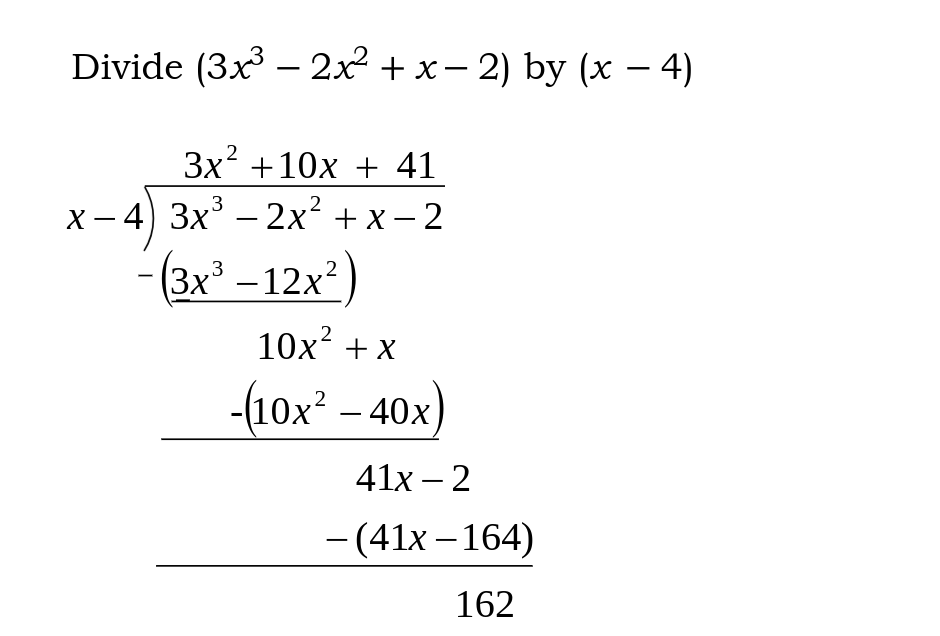

READ: https://planetcalc.com/8332/
https://planetcalc.com/8368/
https://stackoverflow.com/questions/51250851/yuns-algorithm

In [316]:
def divide_poly(a: list, div: list, p: list):
    degree_a = deg(a)
    degree_div = deg(div)
    res = [0] * (degree_a - degree_div + 1)
    degree_res = deg(res)
    quotant = a.copy()
    for i in range(len(res)):
        # first element
        res[i] = (quotant[i] * modinv(div[0],p)) % p
        # multiply
        tmp = [0] * (degree_res - i + degree_div + 1)
        for slot_pos in range(len(tmp)):
            if slot_pos > degree_div:
                tmp[slot_pos] = 0
            else:
                tmp[slot_pos] = res[i] * div[slot_pos]
        # substract
        for item in range(len(a)-len(tmp),len(a)):
            quotant[item] = (quotant[item] - tmp[item-(len(quotant)-len(tmp))]) % p
    return res, quotant
        



def modinv(a,p):
    return pow(a,-1,p)

def deg(a: list):
    return len(a) - 1

a = [3, -2, 1, -2]
b = [1, -4]

a = [3,-5,10,-3]
b = [3,4,3,4]
c = [2,4]
d = [3,1]

a = [647672855160326086372201838131634627840, 646307842055813580955805097872941764597, 265292567099201986356970597216281833574, 70459362186629711235308445852585951232, 264]
print(f"{p = }")
results, quotant = divide_poly(a,c,p)
def print_poly(poly: list):
    degree = deg(poly)
    for i in range(len(poly)):
        print()
        if i == degree:
            print(f"{poly[i]}")
        elif poly[i] == 0:
            continue
        elif i == degree - 1:
            print(f"{poly[i]}*x", end=" + ")
        else:
            print(f"{poly[i]}*x^{degree-i}", end=" + ")
print_poly(a)
print_poly(c)
print_poly(results)
print_poly(quotant)

p = 680564733841876926926749214863536422919

647672855160326086372201838131634627840*x^4 + 
646307842055813580955805097872941764597*x^3 + 
265292567099201986356970597216281833574*x^2 + 
70459362186629711235308445852585951232*x + 
264

2*x + 
4

323836427580163043186100919065817313920*x^3 + 
15763432788519167569075318236604465918*x^2 + 
101119417972562658040334662134931984951*x + 
513555578990066466463734113519965428633





668036619407241841852060405374283977408
